This jupyter notebook includes the most straightforward GAN model that can be used for image generation. To test the code, it is applied for generating images of letter A. It can be also applied for human face generation but it might require fine tuning as adding more layers, change hypreparameters, changing the output size for the generator and input size for the discriminator.

# Check for GPU

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Import Modules

In [ ]:
# Sequential is imported to create model layer by layerwhere data is associated using top to bottom flow
# Model is imported to define a nueral network
from tensorflow.keras.models import Model, Sequential

# The layers to be used in the generator and discrominator
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, Conv2DTranspose, Reshape, MaxPooling2D, BatchNormalization, LeakyReLU
# For an optimal set of weights and biases that minimize the loss function
from tensorflow.keras.optimizers import Adam

# Transform data to numpay arrays and create random noise
import numpy as np
# To load data
import pandas as pd 
# To plot generated images
import matplotlib.pyplot as plt 
# To map numeric values to strings
import string


# Load and Preprocess Data

In [ ]:
!unzip "/content/A_Z Handwritten Data.zip" -d "/content/data/"

Archive:  /content/A_Z Handwritten Data.zip
  inflating: /content/data/A_Z Handwritten Data.csv  


## Load and print Dataset

In [ ]:
# Import the data “A_Z Handwritten Data.csv” from csv
dataset = pd.read_csv('/content/data/A_Z Handwritten Data.csv').astype('float32') 
# Define image dimensions
width, height, channel = 28, 28, 1 
# Visualize the first 5 rows
dataset.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As shown in the above tabular plot the dataframe index column is represented by numbers. These numbers do not represent pixels, instead they are numbers from 0 to 26 which corresponds to text labels. For example 0 maps to A and 1 maps to B. For handwritten images of letter A generation data preprocessing is needed to keep all pixel values with label 0.

## Keeping letter A

In [ ]:
# Create a dictionary to map numbers to the alphabets 
letters = dict(zip(range(0, 26), string.ascii_uppercase))

# Rename first column as letters by index
dataset.rename(columns={dataset.columns[0]: 'letters'},inplace=True)

# Map numerical values in letters column to alphabets using letters dict.
dataset['letters'] = dataset['letters'].map(letters)

# Create a new data frame that contains images of the letter A only
letter_A_images = dataset[dataset['letters'] == 'A']

## Preprocess image pixels by reshaping and normalizing data

In [ ]:
#remove first column in data since it is a row counter
data = letter_A_images.iloc[:,1:].to_numpy()

#reshape data as the shape of the image
data =  data.reshape((data.shape[0], width, height))

#normalize data between [0,1] by deviding by total pixels
data = data/255

#shuffle data to build a randomized data
np.random.shuffle(data)

## Visualize the Dataset

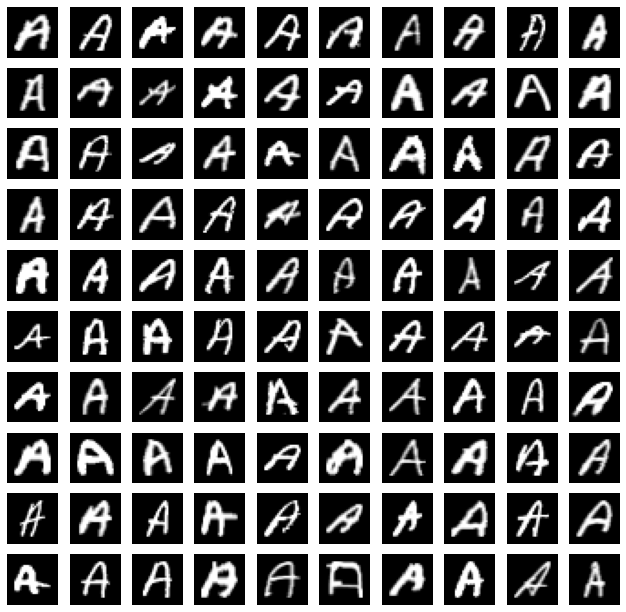

In [ ]:
# Set figure size
plt.figure(figsize=(11,11))
    
i = 1
#loop over all generated images
for img in data:
    if i<=100:
      #make a subplot in order to plot the images beside each other
      plt.subplot(10, 10, i)
      #use the imshow from matplotlib library to show images by specifing their shape
      plt.imshow(img.reshape((height,width)), cmap='gray')
      plt.axis('off')
    i+=1
plt.show()

#Build the geneator network

In [ ]:
def build_generator():
  '''
  padding = 'same' means pad edges with extra fake pixels =0 in order to allow the original
  edges of the image be at the center when kernel slides, the number of zero-padded elements 
  is calculated such that the output feature maps have the same height and width as the input 
  feature maps. 
  Convolution Transpose = is used because in the generator we start with a random noise and 
  upsample to reach the size of the image in the final layer
  image size in this case is 28*28*1
  BatchNormalization = is used to normalize the activations of the layer and to improve the 
  stability and efficiency of the training process
  leaky ReLU = is used in the Convolution Transpose layer to address the vanishing gradients
  problem
  alpha in leaky ReLU is the value that determines the slope of the leaky ReLU activation 
  function for negative values
  '''
  # Add layers one after one in the sequence
  model = Sequential() 
  # First fully connected layer
  model.add(Dense(7*7*128, use_bias=False, input_shape=(100,)))
  # Add LeakyReLU activation function
  model.add(LeakyReLU(alpha=0.01))
  # Reshape the output to be suitable for the Conv2DTranspose layer
  model.add(Reshape((7, 7, 128)))
  # Up-sample to 14x14
  model.add(Conv2DTranspose(128, (1, 1), strides=(2, 2), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))
  # Up-sample to 28*28
  model.add(Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = 'same', activation = 'sigmoid'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))      
  # Output layer with the shape of image w*h*c = 28*28*1
  model.add(Conv2D(1, (5,5), activation = 'sigmoid', padding = 'same'))
  return model

# Build the discriminator

In [ ]:
def build_discriminator():
  '''
  The output size of a convolution operation can be calculated as follows:
  O = (W - K + 2P)/S + 1
  where:
    O is the output size (height or width)
    W is the input size (height or width)
    K is the kernel size (height or width)
    P is the padding size
    S is the stride size
  '''
  # Add layers one after one in the sequence
  model = Sequential() #to add layers one after one in the sequence
  # Conv2D layer with 128 filters and output (28, 28, 128)               
  model.add(Conv2D(128, (2, 2), strides=(1, 1), padding = 'same', input_shape = [28, 28, 1]))
  model.add(LeakyReLU(alpha=0.02))
  # Decrease the height and the width of the output tensor by downsampling to 14*14
  model.add(MaxPooling2D(2,2))
  # Conv2D layer with 64 filters and output (14, 14, 64)    
  model.add (Conv2D(64, (2, 2), strides=(1, 1), padding='same')) 
  model.add(LeakyReLU(alpha=0.02))
  # Down sample to 7*7
  model.add(MaxPooling2D(2,2))
  # Conv2D layer with 32 filters with output (7, 7, 32)
  model.add(Conv2D(32, (2, 2), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.02))
  # Down sample to 3*3
  model.add(MaxPooling2D(2,2))
  # Convert the tensor into a 1D vector with output (288,)
  model.add(Flatten())
  # Prevent overfitting
  model.add(Dropout(0.5))
  # Produce binary classifier
  model.add(Dense(1, activation='sigmoid'))
  return model

#Construct Models

In [ ]:
def construct_models():
    #build the discriminator model
    discriminator = build_discriminator()
    # compile the discriminator
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4, beta_1=0.5), metrics=['accuracy'])

    #build the generator model
    generator = build_generator()

    #pit the generator and discriminator agains each other
    gan = Sequential()
    gan.add(generator)
    gan.add(discriminator)
    #feoze the discriminator during generator training
    discriminator.trainable = False 
    gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4, beta_1=0.5), metrics=['accuracy'])

    return generator, discriminator, gan

#Create Loss Functions

In [ ]:
def disc_loss(model, X, y):
  '''
  A function that takes the mode, image data (X) whether real or fake, 
  and labels (y) whether real or fake and return ths discriminator loss
  '''
  # Train the model on a batch of data and return the loss value
  return model.train_on_batch(X,y)

def gen_loss(model, X, y):
  '''
  A function that takes the model, noise (X), 
  and fake labels (y) and returns the generator loss
  '''
  # Train the model on a batch of data and return the loss value
  return model.train_on_batch(X,y)

#Print Generated Images

In [ ]:
def print_generated_images(noise):
  '''
  A function that takes the random generated noise, generates the images and plots them
  '''
  #use the trained generator to generate images from noise
  gen_imgs = generator.predict(noise)
  #set the figure sise
  plt.figure(figsize=(11,11))
    
  i = 1
  #loop over all generated images
  for img in gen_imgs:
    if i<=100:
      #make a subplot in order to plot the images beside each other
      plt.subplot(10, 10, i)
      #use the imshow from matplotlib library to show images by specifing their shape
      plt.imshow(img.reshape((height,width)), cmap='gray')
      plt.axis('off')
    i+=1
  plt.show()

#Training Loop

In [ ]:
def training(generator, discriminator, gan, real_images, noise_dim, epochs, batch_size):
    # create a random normal variable for generator input
    noise = np.random.normal(0, 1, [batch_size, noise_dim])
    # to set the batch size
    steps = len(data) // batch_size

    # enumerate over epochs
    for e in range(epochs):
        # enumerate batches over the training data
        for b in range(steps):
            # create fake images by the generator
            fake_images = generator.predict(noise)

            # get a random real images from the training data
            real_imgs = data[np.random.randint(0, real_images.shape[0], size=batch_size)]
            # reshape the images
            real_imgs = real_imgs.reshape((batch_size, width, height, channel))

            # generate fake labels generated images as zeros
            fake_labels = np.zeros([batch_size, 1])
            # generate real labels for real data as ones
            real_labels = np.ones([batch_size, 1])

            # combine both true an generated data
            combined_data = np.concatenate([real_imgs, fake_images])
            # Create labels for generated and real data with size of real_image_batch_size + generated_image_batch_size = 2*batch_size
            label = np.zeros(2 * batch_size)
            # divide labels into zeros and ones
            label[:batch_size] = 1

            discriminator.trainable = True
            # calculate the loss of real images
            discriminator_loss = disc_loss(discriminator, combined_data, label)

            # freeze the generator
            discriminator.trainable = False
            # calculate the generator loss
            noise = np.random.normal(0, 1, [batch_size, noise_dim])
            generator_loss = gen_loss(gan, noise, real_labels)

            # if the remainder of dividing current epoch number by 10 equal to 0 print the following image
            if e % 10 == 0:
                print('Epoch: ', e, ' Generator Loss: ', generator_loss, ' Discriminator Loss: ', discriminator_loss)

        # if this is the last ephoch print the generated images
        if e % 10 == 0 or e == epochs-1:
            print_generated_images(noise)

#Run the code

In [ ]:
generator, discriminator , gan = construct_models() #construct the models
training(generator, discriminator, gan, data, 100, 200, 128) #train GAN